In [14]:
import torch
import matplotlib.pyplot as plt
import pandas as pd

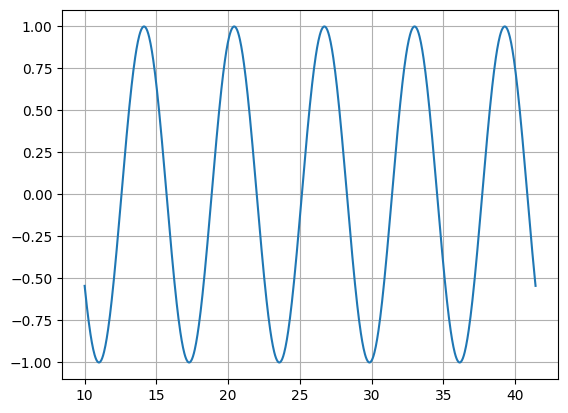

In [15]:
# generate data for sin wave
# should be sliding window as input and next value as output

def generate_sin_values(start):
    x_values = torch.linspace(start,start + 10*torch.pi, 1000)
    sin_values = [torch.sin(i).item() for i in x_values]
    return x_values, sin_values

x_values, sin_values = generate_sin_values(10)

plt.plot(x_values, sin_values)
plt.grid()

In [16]:
# define sliding window where output is next ent
from torch.utils.data import TensorDataset, DataLoader
batch_size = 10
seq_length = 100
def get_sin_data(start_values = 10):
    seqs = []
    targets = []

    x_values, sin_values = generate_sin_values(start_values)

    for idx, sin_val in enumerate(sin_values[:-(seq_length+1)]):

        seq = sin_values[idx: idx+seq_length]
        seqs.append(seq)
        target = sin_values[idx+seq_length]
        targets.append(target)

    inputs = torch.tensor(seqs)
    targets = torch.tensor(targets)
    #print(inputs.shape)
    #print(targets.shape)

    assert(inputs[0,1] == inputs[1,0])
    assert(inputs[1][-1] == targets[0])

    data = TensorDataset(inputs, targets)
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False)

    return dataloader, x_values, sin_values

dataloader, _, _ = get_sin_data()


In [17]:
xs, ys = next(iter(dataloader))
print(xs.shape)
print(ys.shape)

xs.view(len(xs), -1, 1).shape

torch.Size([10, 100])
torch.Size([10])


torch.Size([10, 100, 1])

In [18]:
# define architecture
import torch.nn as nn
class SinRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1, lstm_layers=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers

        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=lstm_layers,
            #batch_first=True
            )

        self.fc = nn.Linear(self.hidden_size,self.output_size)

        h_init = torch.zeros(lstm_layers,1,self.hidden_size)
        self.hidden = (h_init,h_init)

    def forward(self, seq):
        # input = (batch_size, seq_length, features_size)
        # (h0, c0)
        # h0 = (num_layers*num_directions, batch, hidden_size)
        # c0 = (num_layers*num_directions, batch, hidden_size)
        #lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1, -1), self.hidden)
        lstm_out, self.hidden = self.lstm(seq.view(len(seq), -1, 1), self.hidden)
        out = self.fc(lstm_out.view(len(seq), -1))
        return out[-1]

torch.manual_seed(42)
model = SinRNN()
model

SinRNN(
  (lstm): LSTM(1, 50)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [19]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.01)

In [20]:
# check number of parameters
for p in model.parameters():
    print(p.numel())

200
10000
200
200
50
1


In [21]:
epochs = 10
torch.device("mps")

for e in range(epochs):

    rand_start = torch.randint(0, 100, (1,)).item()
    dataloader, _, _ = get_sin_data(rand_start)

    for batch, (inputs, targets) in enumerate(dataloader):
        # we are inside a batch. need to unpack
        for idx, seq in enumerate(inputs):
            optimizer.zero_grad()
            h = torch.zeros(model.lstm_layers,1,model.hidden_size)
#            h = torch.zeros(model.lstm_layers,batch_size,model.hidden_size)
            inputs = inputs.to("mps")
            model.to("mps")
            seq = seq.to("mps")
            h = h.to("mps")
            targets = targets.to("mps")

            model.hidden = (h,h)
            y_pred = model(seq)
            y_pred.to("mps")
            loss = criterion(y_pred, targets[idx].flatten())
            loss.backward()
            optimizer.step()

    print(f"epoch: {e} Loss: {loss}")
#    eval(model)


epoch: 0 Loss: 0.0064028301276266575
epoch: 1 Loss: 0.0007508393027819693
epoch: 2 Loss: 0.004142181947827339
epoch: 3 Loss: 0.00825454480946064
epoch: 4 Loss: 0.003504003630951047
epoch: 5 Loss: 0.005146409850567579
epoch: 6 Loss: 0.007320902775973082
epoch: 7 Loss: 0.0013499725610017776
epoch: 8 Loss: 0.0031889525707811117
epoch: 9 Loss: 0.005144177936017513


x_test_values.shape torch.Size([1000])
y_test_values.shape 1000
y_preds.shape torch.Size([899])


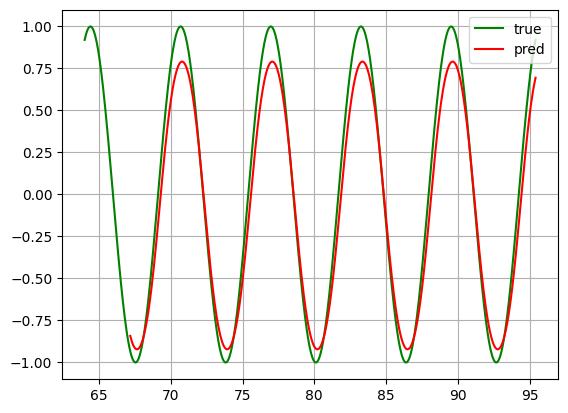

In [64]:
def eval(model, rand_start=20):
    model.eval()
    test_dataloader, x_test_values, y_test_values = get_sin_data(rand_start)

    y_preds = []
    for batch, (inputs, targets) in enumerate(test_dataloader):
        for idx, seq in enumerate(inputs):
            h = torch.zeros(model.lstm_layers,1,model.hidden_size)

            model.to("mps")
            h = h.to("mps")
            seq = seq.to("mps")
            targets = targets.to("mps")

            model.hidden = (h,h)
            y_pred = model(seq)
            y_preds.append(y_pred)

    y_preds = torch.tensor(y_preds)

    print(f"x_test_values.shape {x_test_values.shape}")
    print(f"y_test_values.shape {len(y_test_values)}")
    print(f"y_preds.shape {y_preds.shape}")

    plt.plot(x_test_values, y_test_values, label="true", color="green")
    plt.plot(x_test_values[len(x_test_values)-len(y_preds):], y_preds, label="pred", color="red")
    plt.grid()
    plt.legend(loc="best")
    model.train()

rand = torch.randint(0, 100, (1,)).item()
eval(model, rand)

tensor([0.7287, 0.7498], device='mps:0')
tensor([0.7498, 0.5720], device='mps:0')
tensor([0.5720, 0.5193], device='mps:0')
tensor([0.5193, 0.4688], device='mps:0')
tensor([0.4688, 0.4206], device='mps:0')
tensor([0.4206, 0.3743], device='mps:0')
tensor([0.3743, 0.3299], device='mps:0')
tensor([0.3299, 0.2871], device='mps:0')
tensor([0.2871, 0.2458], device='mps:0')
tensor([0.2458, 0.2059], device='mps:0')
tensor([0.2059, 0.1673], device='mps:0')
tensor([0.1673, 0.1299], device='mps:0')
tensor([0.1299, 0.0935], device='mps:0')
tensor([0.0935, 0.0582], device='mps:0')
tensor([0.0582, 0.0240], device='mps:0')
tensor([ 0.0240, -0.0093], device='mps:0')
tensor([-0.0093, -0.0416], device='mps:0')
tensor([-0.0416, -0.0730], device='mps:0')
tensor([-0.0730, -0.1035], device='mps:0')
tensor([-0.1035, -0.1330], device='mps:0')
tensor([-0.1330, -0.1615], device='mps:0')
tensor([-0.1615, -0.1891], device='mps:0')
tensor([-0.1891, -0.2158], device='mps:0')
tensor([-0.2158, -0.2415], device='mps:0'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


torch.Size([1000])
torch.Size([100])


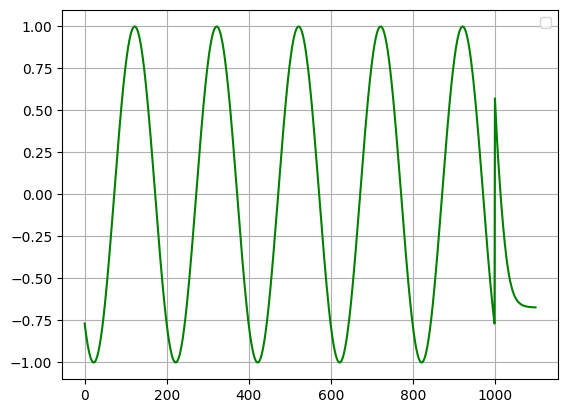

In [69]:
def forecast(model):
    model.eval()

    rand = torch.randint(0, 100, (1,)).item()
    test_dataloader, x_test_values, y_test_values = get_sin_data(rand)
    inputs, targets = next(iter(test_dataloader))

    y_forecast = []

    init_seq = inputs[0].to("mps")
    for i in range(0,100):

        h = torch.zeros(model.lstm_layers,1,model.hidden_size)
        model.to("mps")
        h = h.to("mps")

        # prepare hidden
        model.hidden = (h,h)

        # forecast to new value
        y_fore = model(init_seq)

        # append to predictions
        y_forecast.append(y_fore)

        # create new input
        y_fore = torch.tensor([y_fore.item()]).to("mps")
        init_seq = torch.cat([init_seq[1:], y_fore])

        #print forecasted value
        print(init_seq[-3:-1])

    y_forecast = torch.tensor(y_forecast)
    y_test_values = torch.tensor(y_test_values)
    print(f"{y_test_values.shape}")
    print(f"{y_forecast.shape}")
    y_values = torch.cat([y_test_values, y_forecast])

    plt.plot(range(0, len(y_values)), y_values, color="green")
#    plt.plot(x_test_values[len(x_test_values)-len(y_preds):], y_preds, label="pred", color="red")
    plt.grid()
    plt.legend(loc="best")

    model.train()

c = forecast(model)
